In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### USE "VAE" IPYKERNEL!

In [2]:
import os
cwd = os.getcwd()
print(cwd)

/scratch/connectome/dyhan316/VAE_ADHD



## 1. 준범쌤 dataset코드를 보자! (main.py, dataset등등에 흩어져 있음)
### PRETRAINING일때 config 로 설정해서 dataset/dataloader을 보자 (junbeom쌤 코드 보는중)

**할 것 : **
* barlow config만들기
* dataset의 __getitem__이 우리꺼랑 쌤꺼랑 다르니 수정하기
* main.py에 있던 train test split, label들 불러오기 등등을 최대한 dataset.py내에서 처리하도록 하기
    * 밑에적힌 코드들이 dataset을 만들기 위해서 필요한, dataset뿐만이 아닌 거의 모든 아이들을 다 가진다 (main.py등등) 따라서, **밑의 코드들을 starting page에서 밑의 코드들을 잘 조합해야할듯)**

In [3]:
#from config.py

from cmath import nan
PRETRAINING = 0
FINE_TUNING = 1
class Config : 
    def __init__(self, mode):
        assert mode in {PRETRAINING, FINE_TUNING}, "Unknown mode: %i"%mode
        self.mode = mode
    
        if self.mode == PRETRAINING:
            self.batch_size = 8 # ADNI
            self.nb_epochs_per_saving = 1
            self.pin_mem = True
            self.num_cpu_workers = 8
            self.nb_epochs = 100 # ADNI #####
            self.cuda = True
            # Optimizer
            self.lr = 1e-4
            self.weight_decay = 5e-5
            # Hyperparameters for our y-Aware InfoNCE Loss
            self.temperature = 0.1
            self.tf = 'all_tf' # ADNI
            self.model = 'DenseNet' # 'UNet'
            ### ADNI
            self.data = '/scratch/connectome/study_group/VAE_ADHD/data' # ADNI
            self.label = '/scratch/connectome/dyhan316/VAE_ADHD/junbeom_finetuning/csv/fsdat_baseline_CN.csv' # ADNI
            self.valid_ratio = 0.25 # ADNI (valid set ratio compared to training set)
            self.input_size = (1, 80, 80, 80) # ADNI #####
            
            self.label_name = ['PTAGE', 'PTGENDER'] # ADNI
            self.label_type = ['cont', 'cat'] # ADNI
            self.cat_similarity = [nan, 0] # similarity for mismatched categorical meta-data. set nan for continuous meta-data
            self.alpha_list = [0.5, 0.5] # ADNI # sum = 1
            self.sigma = [5, 5] # ADNI # depends on the meta-data at hand
            
            self.checkpoint_dir = './ckpts' # ADNI
            self.patience = 20 # ADNI
        

주의 : The `self.label_name`, `self.label_type` are used as the METADATA for yAware pretraining

In [4]:
config = Config(mode = 0)

In [5]:
#from dataset.py

from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import torch
from yAwareContrastiveLearning.augmentations import Transformer, Crop, Cutout, Noise, Normalize, Blur, Flip
### ADNI
import os
import nibabel as nib
from skimage.transform import resize
from scipy import stats

class ADNI_Dataset(Dataset):

    def __init__(self, config, data_csv, data_type, *args, **kwargs): # ADNI
        super().__init__(*args, **kwargs)
        
        ### ADNI
        self.config = config
        self.data_type = data_type
        self.transforms = Transformer()
        self.transforms.register(Normalize(), probability=1.0)

        if self.data_type == 'train' or self.config.mode == 0:
            if self.config.tf == "all_tf":
                self.transforms.register(Flip(), probability=0.5)
                self.transforms.register(Blur(sigma=(0.1, 1)), probability=0.5)
                self.transforms.register(Noise(sigma=(0.1, 1)), probability=0.5)
                self.transforms.register(Cutout(patch_size=np.ceil(np.array(self.config.input_size)/4)), probability=0.5)
                self.transforms.register(Crop(np.ceil(0.75*np.array(self.config.input_size)), "random", resize=True),
                                        probability=0.5)

            elif self.config.tf == "cutout":
                self.transforms.register(Cutout(patch_size=np.ceil(np.array(self.config.input_size)/4)), probability=1)

            elif self.config.tf == "crop":
                self.transforms.register(Crop(np.ceil(0.75*np.array(self.config.input_size)), "random", resize=True),
                                        probability=1)
        
        self.data_dir = self.config.data ###CHANGED### #'./adni_t1s_baseline'
        self.data_csv = data_csv
        self.files = [x for x in os.listdir(self.data_dir) if x[4:12] in list(self.data_csv['SubjectID'])]
        ###
        
    def collate_fn(self, list_samples):
        list_x = torch.stack([torch.as_tensor(x, dtype=torch.float) for (x, y) in list_samples], dim=0)
        list_y = torch.stack([torch.as_tensor(y, dtype=torch.float) for (x, y) in list_samples], dim=0)

        return (list_x, list_y)

    def __getitem__(self, idx):
        # For a single input x, samples (t, t') ~ T to generate (t(x), t'(x))
        ### ADNI
        if self.config.mode == 0: # Pre-training # consider multiple labels (list)
            labels = []
            for label_nm in self.config.label_name: # ["PTAGE", "PTGENDER"]
                labels.append(float(self.data_csv[label_nm].values[idx]))
            labels = tuple(labels)
        else: # Fine-tuning
            labels = self.data_csv[self.config.label_name].values[idx]
        SubjectID = self.data_csv['SubjectID'].values[idx]
        file_match = [file for file in self.files if SubjectID in file]
        path = os.path.join(self.data_dir, file_match[0])
        img = nib.load(os.path.join(path, 'brain_to_MNI_nonlin.nii.gz'))
        img = np.swapaxes(img.get_data(),1,2)
        img = np.flip(img,1)
        img = np.flip(img,2)
        img = resize(img, (self.config.input_size[1], self.config.input_size[2], self.config.input_size[3]), mode='constant')
        img = torch.from_numpy(img).float().view(self.config.input_size[0], self.config.input_size[1], self.config.input_size[2], self.config.input_size[3])
        img = img.numpy()
        
        np.random.seed()
        if self.config.mode == 0: # Pre-training
            x1 = self.transforms(img)
            x2 = self.transforms(img)
            x = np.stack((x1, x2), axis=0)
        else: # Fine-tuning
            x = self.transforms(img)
        ###

        return (x, labels)

    def __len__(self):
        return len(self.data_csv)

In [6]:
#actually building it 

#DOITDOITDOIT

In [7]:
#from main.py (temporary, parser을 args로 바꾸기 위한 것 )
class Args():
    def __init__(self):
        self.train_num = 10
        self.random_seed = 0
args = Args()

In [8]:
#from main.py (실제로 data만들고 등등 하기 => 이것을 dataset딴으로 옮겨도 될듯?)
random_seed = args.random_seed
label_name = config.label_name


data = pd.read_csv(config.label)
for i in range(len(label_name)): # ["PTAGE", "PTGENDER"]
    if config.label_type[i] != 'cont': # convert str object to numbers
        data[label_name[i]] = pd.Categorical(data[label_name[i]])
        data[label_name[i]] = data[label_name[i]].cat.codes

#assert args.train_num*(1+config.valid_ratio) <= len(data), 'Not enough valid data. Set smaller --train_num or smaller config.valid_ratio in config.py.'
label_train, label_valid, label_test = np.split(data.sample(frac=1, random_state=random_seed), 
                                                [args.train_num, int(args.train_num*(1+config.valid_ratio))])

In [9]:
#from main.py ACTUALLY CALLING THE ADNI DATASET
dataset_train = ADNI_Dataset(config, label_train, data_type = 'train')

In [10]:
len(dataset_train)

10

In [11]:
type(dataset_train[0]),type(dataset_train[0][0]), dataset_train[0][0].shape, dataset_train[0][1] #PTAGE, PTGENDER을 저 두가지로 표현한 듯 

/tmp/ipykernel_1117003/3651460512.py:66: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img = np.swapaxes(img.get_data(),1,2)


(tuple, numpy.ndarray, (2, 1, 80, 80, 80), (70.8, 0.0))

/tmp/ipykernel_1117003/3651460512.py:66: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img = np.swapaxes(img.get_data(),1,2)


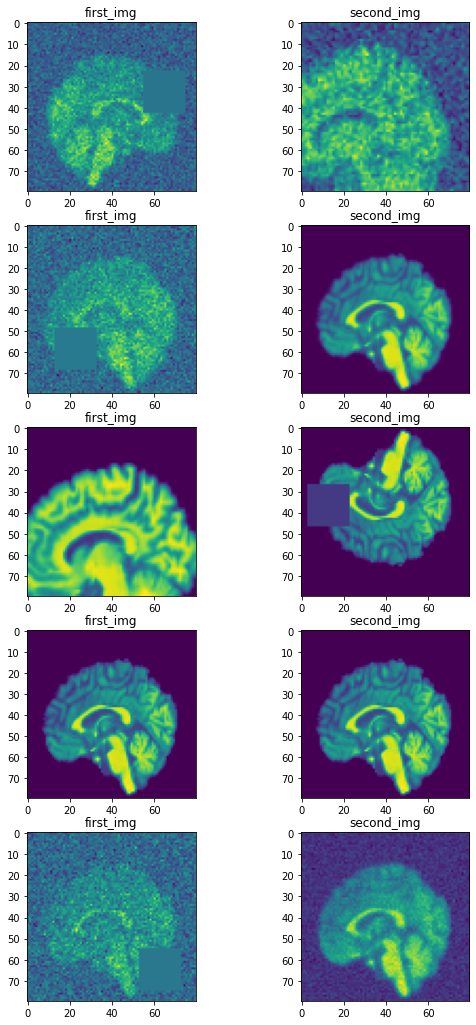

In [12]:
#print the junbeom things
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5,2, figsize = (9,18))

for i in range(5):
    axs[i,0].imshow(dataset_train[0][0][0,0,40])
    axs[i,0].set_title("first_img")
    
    axs[i,1].imshow(dataset_train[0][0][1,0,40])
    axs[i,1].set_title("second_img")

# 2. 우리가 짰던 barlowtwins dataset을 보기 (둘이 비슷한지 보기 위해서)

#### for checking the actual thing

In [14]:
from barlowtwins import dataset_UKB

data_pth = '/scratch/connectome/3DCNN/data/1.ABCD/1.sMRI_fmriprep/preprocessed_masked'
dataset_org = dataset_UKB.UKB_T1(data_path = data_pth, split = 'train', transform = dataset_UKB.Transform_yAware())

In [15]:
type(dataset_org[0]), type(dataset_org[0][0]), type(dataset_org[0][1])


(tuple, tuple, numpy.int64)

In [16]:
#나중 custom dataset만들었을때 (밑에서) 이것과 비교하는 용 
loader = torch.utils.data.DataLoader(dataset_org, batch_size = 8, num_workers = 4, pin_memory = True)
for i in loader:
    print(type(i))
    print(len(i))
    print(type(i[0]))
    print(len(i[0]))
    print(i[0][0].shape, i[0][1].shape)
    break

RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "/home/connectome/dyhan316/.local/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 34, in _pin_memory_loop
    data = pin_memory(data)
  File "/home/connectome/dyhan316/.local/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 65, in pin_memory
    return type(data)([pin_memory(sample) for sample in data])  # type: ignore[call-arg]
  File "/home/connectome/dyhan316/.local/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 65, in <listcomp>
    return type(data)([pin_memory(sample) for sample in data])  # type: ignore[call-arg]
  File "/home/connectome/dyhan316/.local/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 65, in pin_memory
    return type(data)([pin_memory(sample) for sample in data])  # type: ignore[call-arg]
  File "/home/connectome/dyhan316/.local/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 65, in <listcomp>
    return type(data)([pin_memory(sample) for sample in data])  # type: ignore[call-arg]
  File "/home/connectome/dyhan316/.local/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 50, in pin_memory
    return data.pin_memory()
RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.


In [ ]:
dataset_org[0][0][0].is_cuda #즉, 여전히 CPU에서 만들어진다

## 2.X yAware vs Barlowtwins차이점


우리가 dataset바꿀때, 밑의 (다른) 점들을 고려해서 yAware을 수정해야한다

1. data_dir의 차이
    * yAware는 file strcutrue이 subject folder/brain_to_nonlinear.nii.gz 이런꼴
    * barlow는 file 내에 *.npy* 로 파일 이 다 있는 것 
    
    (즉, 희환쌤 ABCD 데이터랑 준범썜 ADNI 데이터랑 데이터스트럭쳐가 다름)
        * 두가지다 가능하도록 dataset을 수정하기 

2. ouptput이 다름 (밑에 사진 참조)
    * 둘다 tuple이기는 하나, yAware은 두 img를 ndarray로 합쳤고 barlow는 tuple 로 했다 (둘다 괜찮을수도?)

3. init에서 만드냐 유무가 다름!
4. UKB_T1은 함수이나 (return the imagedataset) yAware에서는 진짜 dataset자체를 정의

4. 그리고 config의 유무도 다름! 이것도 주의해야할듯     
#### 위에서 보듯이 둘의 다른 점이 있으니, `parser model : model (barlow or yAware)`로 받아서 두 경우에 따라 dataset이 flexible하게 되던지 해야할듯 (if else문 써서)
* 아니다! 그냥 barlowtwins용 dataset.py를 따로 만들자 (솔직히 pretraining은 barlowtwins로만 하고 finetuning은 finetuning대로 할 것이니)
    * 대신 csv파일은 얻어서 처리하는 것이 똑같도록 하기! (ouput등이 다르더라도)
    * 다만 이러면 문제점이, 만약 **ABCD 으로PRETRAINING/FINETUNING** 둘다 하려고 한다면 (즉, same file structure을 두번 쓰려고 한다면), 두개의 다른 dataset을쓰게 될 것이니 에러가 뜰것
        * 이 경운, `dataset.py`에서 종류를 `ADNI_Dataset`말고 `UKB_Dataset`이라고 따로 만들어서 처리하도록 하자
 


**어떤 일이 되던, yAware을 우리가 벤치마킹해야하는게, evaluation등에 쓸때 demo/csv 파일을 따로 만들어주는 것은 바보같은 짓이니, yAware로 통일해야한**


그리고 이렇게 바꾸면 evaluatino 파트에서도 바뀔 수 있다 => 조심해서 봐야할듯 


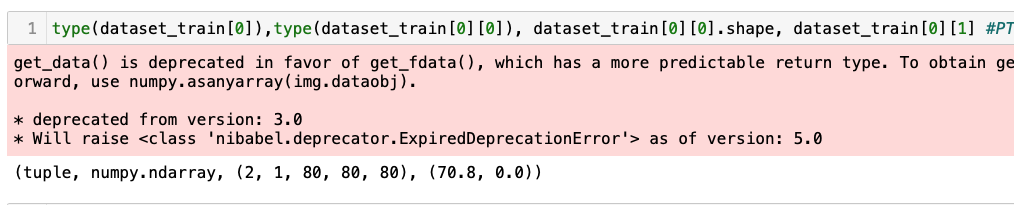

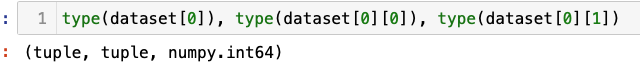

# 3. 실제로 dataset.py를 만들기 (yAware에서 개조)

가정 : `config = Config(mode = 0)` 까지는 이미 위에서 한 그대로 쓴다고 가정 
(dataset.py내에있는 것만 일단 바꾸고, 바꾸는데 성공하 config을 처리하기)

In [ ]:
from barlowtwins.dataset_UKB import *
import matplotlib.pyplot as plt 
#from nilearn import plotting #torch tensor not compatible with nilearn
import torch
from monai.transforms import *


# #try : barlow twins처럼 ImageDataset을 return하되, getitem으로 다른 것을 가져오게 하기? 

 # 근데 흠... 원래는 getitem이 있어야 하나 barlowtwins에서 우리는 dataset자체를 return했어서 문제가 없었따

 # 따라서 조금더 구체적으로 따져봐서, ImageDataest으로 init에서 initialize한후 (for faster loading), getitem으로 augmentation을 

 # randomly하게 쉽게 할 수 있을지 봐야겠다

* numpy or tensor => finished
* scale intensity/normalize intensity => finished
* no collate, make sure dataloader creating works => finished
* two outptus => finished

* actually putting in the labels (supervised SSL할떄 쓰기?)

In [ ]:
##TRYING TO CREATE NEW DATASET
import numpy as np
import monai
from monai.data import ImageDataset
from monai.transforms import ScaleIntensity, ResizeWithPadOrCrop, NormalizeIntensity, ToTensor, EnsureChannelFirst, ToNumpy
from pathlib import Path
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset

from barlowtwins.augmentations import Transformer, Crop, Cutout, Noise, Normalize, Blur, Flip


class basic_transform():
    """
    basic transform for creating the dataset in the first place 
    (MNI로 fixed input size 면 not resize하고 등등)
    
    MNI : if true, does not apply ResizeWithPadOrCrop, but if false, applies the spatial size that was given by **kwargs
    """
    def __init__(self, MNI = True, **kwargs):
        transform_list = [EnsureChannelFirst()]  #removed scale intensity
                    
        #add padding/cropping if not MNI (i.e. shape varies)
        shape_no_channel = kwargs['shape'][1:] #shape without the channel dimension, as that should be used when doing Resizewithpadorcrop
        transform_list.append(ResizeWithPadOrCrop(spatial_size =  shape_no_channel, method = "symmetric", mode = "edge")) if MNI == False else None

        #adding the normalize intensity To Tensor things 
        transform_list = transform_list + [NormalizeIntensity(), ToNumpy()]
            #ToNumpy instead of tensor because transform yAware is implemnetned in numpy
        
        self.transform = monai.transforms.Compose(transform_list)        

    def __call__(self, x):
        return self.transform(x)          

##changed function UKB_T1 to MRI_dataset
class MRI_dataset(Dataset):
    """
    split = 'train' or 'test'
    split_prop = '0~1'사이, how much to take as training for splitting
    transform = transform to be performed
    shape = shape of the image (MUST INCLUDE CHANNEL)
        * if MNI==True, does not do cropping or anything
        * if MNI==False, apply ResizeWithPadOrCrop
    MNI = fixed shape or not
    """
    
    def __init__(self,data_path, split, split_prop, transform, shape, MNI= True):
        assert len(shape) == 4, "shape must be given WITH the channel too! (C, H, W, D)"
        self.shape = shape #make it into channel
        self.split = split #split여부 tracking하기 
        
        
        ##getting list of img paths 
        imgs = sorted([f for f in Path(data_path).iterdir() if f.suffix != ".txt"]) #txt가 들어있는 경우가 있어서 제외
        
        ##GETTING LABELS : NOT IMPLEMENTED YET, SO ZERO... BUT FOLLOWING yAware's way 
        lbls = np.zeros(len(imgs))
        lbls = lbls.astype(int)
        
        ##TRAIN TEST SPLIT
        imgs = imgs[:int(len(imgs)*0.75)] if split == "train" else imgs[int(len(imgs)*0.75):] if split =="test" else print("wrong")

        self.dataset = ImageDataset(image_files=imgs, labels = lbls, transform=basic_transform(MNI = MNI,shape=self.shape ))
                
        if self.split == 'train':
            self.transform = transform(shape = self.shape) #the transform to use 
            self.transform_prime = transform(shape = self.shape) 

    #def collate_fn():#see later (dataloader할때 batch가 이상하면 이쪽을 고쳐야할수도)
    
    def __getitem__(self,idx):
        sub_data = self.dataset[idx]
        sub_img, sub_label = self.dataset[idx] #해당 idx subject의 img뽑기
        
        if self.split == 'train':
            y1 = torch.from_numpy(self.transform(sub_img).copy()).float() #copy done to avoid Torch.from_numpy not support negative strides errors
            y2 = torch.from_numpy(self.transform_prime(sub_img).copy()).float()
            return (y1, y2), sub_label
        
        elif self.split == "test":
            return ToTensor()(sub_img.copy()), sub_label
    
    #define __len__ because needed when loading into dataloader
    def __len__(self):
        return len(self.dataset)
    
###this is done as a basic transform that is performed before creating the dataset
#즉, dataset creation using ImageDataset에서는 basic_transform을 거치고, 
#유일하게 다른 것인 어떤 "transform"을 받았냐는 것 (after creating Image Dataset)


#===========yAware augmentations============#
class transform_yAware_all():
    def __init__(self, shape, **kwargs):
        self.shape = shape
        self.transforms = Transformer()
        
        ##register the transformations
        self.transforms.register(Flip(), probability=0.5)
        self.transforms.register(Blur(sigma=(0.1, 1)), probability=0.5)
        self.transforms.register(Noise(sigma=(0.1, 1)), probability=0.5)
        self.transforms.register(Cutout(patch_size=np.ceil(np.array(self.shape)/4)), probability=0.5)
        self.transforms.register(Crop(np.ceil(0.75*np.array(self.shape)), "random", resize=True), probability=0.5)
    
    def __call__(self, x):
        return self.transforms(x) #so far, numpy array
    
class transform_yAware_crop():
    def __init__(self, shape, **kwargs):
        self.transforms = Transformer()
        
        ##register the transformations
        self.transforms.register(Crop(np.ceil(0.75*np.array(shape)), "random", resize=True), probability=0.5)
    
    def __call__(self, x):
        return self.transforms(x)

class transform_yAware_cutout():
    def __init__(self, shape, **kwargs):
        self.transforms = Transformer()
        
        ##register the transformations
        self.transforms.register(Cutout(patch_size=np.ceil(np.array(shape)/4)), probability=1)

    def __call__(self, x):
        return self.transforms(x)



In [ ]:
data_pth = '/scratch/connectome/3DCNN/data/1.ABCD/1.sMRI_fmriprep/preprocessed_masked'

#SHAPE MUST INCLUDE CHANNEL
base_aug = MRI_dataset(data_pth, "test",1, None,(1, 99, 117, 95),None) #when doing test, do not perform any other augmentations than the base one
all_aug = MRI_dataset(data_pth, "train",1, transform_yAware_all,(1,99, 117, 95), MNI = True)   #when MRI is all the same 
base_non_mni_aug = MRI_dataset(data_pth, "test", 1, None ,shape =  (1,99, 125, 120), MNI = False ) #perform ResizeWithPadOrCrop if MNI = False ot the given hsape


#####other stuff
crop_aug = MRI_dataset(data_pth, "train",1, transform_yAware_crop,(1,99, 117, 95), MNI = True)   #when MRI is all the same 
cutout_aug = MRI_dataset(data_pth, "train",1, transform_yAware_cutout,(1,99, 117, 95), MNI = True)   #when MRI is all the same 

print(base_aug)
print("CHECK IF DOING SCALE INTENSITY OR NORMALIZE IS CORRECT (둘의 차이점과 우리가 써야하는 것 )")

In [ ]:
a = transform_yAware_all((99, 117, 95))


In [ ]:
#a.dataset[0] #제대로 되는 것을 보기 가능 
(base_aug[0][0].shape, base_aug[0][1]), (all_aug[0][0][0].shape ,all_aug[0][0][0].shape , all_aug[0][1])

In [ ]:
import matplotlib.pyplot as plt
import torch 
plt.imshow(base_aug[0][0][0,50])
print(torch.mean(base_aug[0][0]))
print(torch.var(base_aug[0][0]))
print("well normalized, as expected")

IMPLEMENT GETTING THE SHAPE AND MNI 여부

In [ ]:
#print the junbeom things
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3,2, figsize = (9,10))

for i in range(3):
    axs[i,0].imshow(all_aug[0][0][0][0,40])
    axs[i,0].set_title("first_img")
    
    
    im = axs[i,1].imshow(all_aug[0][0][0][0,40])
    axs[i,1].set_title("second_img")
    
    print("mean : ", torch.mean(all_aug[0][0][0]))
    print("var : ", torch.var(all_aug[0][0][0]))
fig.colorbar(im)
print("as expected, different images at different runs")

In [ ]:
plt.imshow(base_non_mni_aug[0][0][0,30]) #할때마다 다른 이미지 나옴 => 잘 되었다!
print("as expected, made with zeor padding in the places")
print(torch.mean(base_non_mni_aug[0][0]))
print(torch.var(base_non_mni_aug[0][0]))
print("normalized, as expected")

### Trying defining the dataset and defining dataloader

In [ ]:
dataset = MRI_dataset(data_pth, "train",1, transform_yAware_all,(1,99, 117, 95), MNI = True)
loader = torch.utils.data.DataLoader(dataset, batch_size = 8, num_workers = 4, pin_memory = True)

In [ ]:
loader = torch.utils.data.DataLoader(dataset, batch_size = 8, num_workers = 4, pin_memory = True)
for i in loader:
    hi = i
    break
hi[0][0].dtype

In [ ]:
loader = torch.utils.data.DataLoader(dataset, batch_size = 8, num_workers = 4, pin_memory = True)
for i in loader:
    new_first = i
    print(type(i))
    print(len(i))
    print(type(i[0]))
    print(len(i[0]))
    print(i[0][0].shape, i[0][1].shape)
    break

print("======")
#now making loader with the original dataset made by 정윤쌤 and seeing if they are the same 
loader = torch.utils.data.DataLoader(dataset_org, batch_size = 8, num_workers = 4, pin_memory = True)
for i in loader:
    old_first = i
    print(type(i))
    print(len(i))
    print(type(i[0]))
    print(len(i[0]))
    print(i[0][0].shape, i[0][1].shape)
    break

In [ ]:
new_first[0][0].dtype, old_first[0][0].dtype

In [ ]:
all_aug.shape, base_non_mni_aug.shape

In [ ]:
a = (1,2)
(1,)+ (1,2)

In [ ]:

#def UKB_T1(data_path, split, transform, **kwargs):
#    imgs = sorted([f for f in Path(data_path).iterdir() if f.suffix != ".txt"]) #txt가 들어있는 경우가 있어서 제외
#
#    lbls = np.zeros(len(imgs))
#    lbls = lbls.astype(int)
#
#    return ImageDataset(image_files=imgs, labels = lbls, transform = transform)


###TRANSFORM은 따로 만들어줘서 하자!

#class Transform_yAware:
#    def __init__(self, MNI = True, **kwargs):
#        ##MNI : if true, does not apply ResizeWithPadOrCrop, but if false, applies the spatial size that was given by **kwargs
#        
#        #transform normalize , flip, blur, noise, (cutout, crop (only if True))
#        transform_list = [
#            ScaleIntensity(), AddChannel(),
#            RandFlip(prob = 0.5),
#            RandGaussianSharpen(sigma1_x=(0.1, 1.0), sigma1_y=(0.1, 1.0), sigma1_z=(0.1, 1.0), sigma2_x=0.1, sigma2_y=0.1, sigma2_z=0.1,prob=0.5)]
#        
#        #add padding/cropping if not MNI (i.e. shape varies)
#        transform_list.append(ResizeWithPadOrCrop(spatial_size =  kwargs['shape'], method = "symmetric", mode = "constant")) if MNI == False else None
#                              
#        transform_list = transform_list + [NormalizeIntensity(),ToTensor()] #append two things at once
#        
#        self.transform_list = transform_list
#        
#        self.transform = monai.transforms.Compose(transform_list)
#        self.transform_prime = monai.transforms.Compose(transform_list)
#        
#
#    def __call__(self, x):
#        y1 = self.transform(x)
#        y2 = self.transform_prime(x)
#        return y1,y2    


##ADD THE NO_AUGMENTATION OPTION TOO!
##ALSO ADD OTHER AUGMENTATIONS WHEN NEEDED

In [ ]:
MNI = True
a=3 if MNI==True else 2
print(a)

밑 : # 기존 데이터셋 (정윤쌤만드신 것) 처럼 하되, yAware의 augmentation을 넣을 수 있는지 보자 
    
결론 : **안됨**

In [ ]:
import numpy as np
import monai
from monai.data import ImageDataset
from monai.transforms import ScaleIntensity, AddChannel, RandFlip, RandGaussianSharpen
from pathlib import Path
import os
import pandas as pd
import numpy as np


###NEW
from yAwareContrastiveLearning.augmentations import Transformer, Crop, Cutout, Noise, Normalize, Blur, Flip



##define dataset (through kinda wrapping over the ImageDataset)
def UKB_T1(data_path, split, transform, **kwargs):
    imgs = sorted([f for f in Path(data_path).iterdir() if f.suffix != ".txt"]) #txt가 들어있는 경우가 있어서 제외
    
    ##밑 : 임시 처방전. 일단 이것 작동하는 지보고, 정윤쌤의 sex class가져다가 쓰기!!!##
    lbls = np.zeros(len(imgs))
    lbls = lbls.astype(int)

    return ImageDataset(image_files=imgs, labels = lbls, transform = transform)


class Transform_yAware:
    def __init__(self, MNI = True, **kwargs):
        ##MNI : if true, does not apply ResizeWithPadOrCrop, but if false, applies the spatial size that was given by **kwargs
        
        #transform normalize , flip, blur, noise, (cutout, crop (only if True))
        transform_list = [
            ScaleIntensity(), AddChannel(),
            RandFlip(prob = 0.5),
            RandGaussianSharpen(sigma1_x=(0.1, 1.0), sigma1_y=(0.1, 1.0), sigma1_z=(0.1, 1.0), sigma2_x=0.1, sigma2_y=0.1, sigma2_z=0.1,prob=0.5)]
        
        #add padding/cropping if not MNI (i.e. shape varies)
        transform_list.append(ResizeWithPadOrCrop(spatial_size =  kwargs['shape'], method = "symmetric", mode = "constant")) if MNI == False else None
        
        
        
        

        transform_list = transform_list + [NormalizeIntensity(),ToTensor()] #append two things at once
        #============try new====================#
        ###Cutout (have to do resizing afterwards)
        crop_shape = np.array([50,50,50])
        crop_shape = crop_shape.astype(int) #make it into integer!!
        self.new_transform = Transformer()
        self.new_transform.register(Crop(crop_shape, "random", resize=True),
                                        probability=0.5)
        transform_list.append(self.new_transform)
        #=======================================#        
        self.transform_list = transform_list
        
        
        
        
        self.transform = monai.transforms.Compose(transform_list)
        self.transform_prime = monai.transforms.Compose(transform_list)
        

    def __call__(self, x):
        y1 = self.transform(x)
        y2 = self.transform_prime(x)
        return y1,y2    


In [ ]:
new_dataset = UKB_T1(data_path = data_pth, split = 'train', transform = Transform_yAware())

In [ ]:
Transform_yAware().transform_list

In [ ]:
new_dataset[0]

In [ ]:
data_pth = '/scratch/connectome/3DCNN/data/1.ABCD/1.sMRI_fmriprep/preprocessed_masked'
np.load(data_pth + '/'+os.listdir(data_pth)[0]).shape

In [ ]:
dataset_train.data_csv

# AUGMENTATINOS를 보기 (근데 이거는 더이상 안봐도 될듯.. 우리는 이미 준범쌤 augmentation/dataset 을 우리도 쓰기로 해서  

## 1. yAware 코드자체의 Augmentations

실제로 yAware에서 어떤 augmentatino을 하는지 보여주는 것을 하기 (현재는 module error이 떠서 나중에 해결해야할듯 
()

ㅌㅌㅌ
ㅌ
ㅌ


ㅌ


ㅌ



In [ ]:
import os 
os.chdir(f'{cwd}/yAwareContrastiveLearning') #잠시 yAware거기로 가자 
from dataset import MRIDataset
from config_jan import Config, PRETRAINING

#config = Config(PRETRAINING)
#dataset_train = MRIDataset(config, training = True)

#디렉토리가 없다고 해서 다시 만들어서 testing해봐야할듯? => 정윤쌤 task? 
os.chdir(cwd) #원래 디렉토리로 돌아오기 

## 2. 우리가 하는 augmentations



### 2.0 일단 실제 이미지에 augmentation몇번 적용하는 것들을 보자 

In [ ]:
from barlowtwins.dataset_UKB import *
import matplotlib.pyplot as plt 
#from nilearn import plotting #torch tensor not compatible with nilearn
import torch
from monai.transforms import *

In [ ]:
data_path = '/scratch/connectome/3DCNN/data/1.ABCD/1.sMRI_fmriprep/preprocessed_masked'
imgs = sorted([f for f in Path(data_path).iterdir() if f.suffix != ".txt"])


In [ ]:
import random

org_img = np.load(imgs[0])
print(org_img.shape)

org_img = AddChannel()(org_img)

img_shape = np.array((99,117,95))



###Noise
sig_range = (0.1,1)
smoothed_img = RandGaussianSmooth(prob = 0.5,sigma_x=sig_range, 
                                  sigma_y=sig_range, 
                                  sigma_z=sig_range)(org_img)
#smoothed_img = RandGaussianSmooth(prob = 1)(org_img) #when doing it absolutely, for testing

###Noise
noise_range = (0.1,1) #selects from random noise range
noise_stdev = random.uniform(*noise_range)
noised_img = RandGaussianNoise(prob = 0.5,
                              std = noise_stdev)(org_img)
#noised_img = RandGaussianNoise(prob=1.0)(org_img) #for demonstration

###Cutout (have to do resizing afterwards)
crop_shape = 0.75*np.ceil(img_shape)
crop_shape = crop_shape.astype(int) #make it into integer!!

#이것은 50의 확률로 하도록 해야함!
crop_img = RandSpatialCrop(roi_size = crop_shape, 
                           random_size = False)(org_img,randomize= True)
crop_img = Resize(spatial_size = img_shape)(crop_img)


In [ ]:
tuple(crop_shape), crop_img.shape

# gaussina smooth 가 사실은 yAware에서 쓴 것 같다 (not the shapren thing, as the mathematics is different)

In [ ]:
#plt.imshow(org_img[50])

plt.imshow(smoothed_img[0,50])
#plt.imshow(noised_img[50])
plt.imshow(crop_img[0,50])

## guassian blur같은 것자체가 random하기도 할수도 있으나, (the stdev) 그 operation을 하냐 마냐 자체가 random할수도 있기에 잘 봐야한다 

In [ ]:
fig, axs = plt.subplots(2,5, figsize = (18,9))
fig.suptitle("comparing MONAI and yAware transformations of the small image")

###1st row  : 
axs[0,0].imshow(org_img[0,50])
axs[0,0].set_title("org_img")

axs[0,1].imshow(smoothed_img[0,50])
axs[0,1].set_title("smoothed_img")

axs[0,2].imshow(noised_img[0,50])
axs[0,2].set_title("noised_img")

axs[0,3].imshow(crop_img[0,40]) #shape cannot be the same becauase random 
axs[0,3].set_title("cropped_img")




In [ ]:
74/2

## 3. yAware augmentations


In [ ]:
from yAwareContrastiveLearning import augmentations

In [ ]:
augmentations.Blur(sigma = (0.1,1))(org_img).shape

In [ ]:
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import torch
from augmentations import Transformer, Crop, Cutout, Noise, Normalize, Blur, Flip

class MRIDataset(Dataset):

    def __init__(self,  training=False, validation=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
        self.transforms = Transformer()
        #self.config = config
        self.transforms.register(Normalize(), probability=1.0)
        
        ##MONAI를 그대로 가져다가 쓰기 가능!
        self.transforms.register(RandFlip(prob = 1), probability=0.5)
        self.transforms.register(RandSpatialCrop(roi_size = crop_shape, random_size = False),probability = 0.5)
    def __getitem__(self,idx):
        #x1 = self.transforms(self.data[idx])
        x1 = self.transforms(np.array(org_img))
        
        return x1
        
        

In [ ]:
a = MRIDataset()[0]

In [ ]:
plt.imshow(a[0,50])
print(a.shape)

# 결론 : 준범쌤의 modified dataset 코드를 그대로 쓰는 것이 낫겠다 (with some modifications)

In [ ]:
##config 여기다가 따로 정의 (config은 나중에 없앨 ㄱ겅ㅅ디 ㅏ)

## Testing with the acutal thing 

In [ ]:
from barlowtwins.dataset_UKB import *

In [ ]:
#MNI false : crop/padding to make it into same size
#MNI True : 

In [ ]:

a = UKB_T1(data_path, split = None, transform=Transform_yAware(MNI = False, shape = (182,218,182)))
#print(Transform_yAware().transform_list)

In [ ]:
type(a[0][0]), type(a[0][1])
img = a[0][0]

a[0][0][0].shape,a[0][0][1].shape 

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(a[0][0][1][0,100])
print(torch.max(a[0][0][1][0,100])) #put the min and mean and so on 
plt.clim(-10, 10) #color range
plt.colorbar()

In [ ]:
if None:
    print("hi")
else :
    print("ho")

# remove split thing in both main_3D.py and UKB_T1


# also transform_yaware에 option을 넣어서 fixed dimensions (MNI-space)일때를 받을 수 있도록 함!

In [ ]:
**[1,3,a]

In [ ]:
b = [2,3,4]
b.append(*['3','5']) if True else None

In [ ]:
b

In [ ]:
def hi(**kwargs):
    print(kwargs)

In [ ]:
hi(ho = 3)

In [ ]:
hi()

In [ ]:
b =  UKB_T1(data_path, split = None, transform=No_Augmentation())


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(b[0][0][0,:,60])